### 한국어 감정 분석기 - 네이버 영화 리뷰

In [42]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [43]:
### 데이터 로드
#urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
#urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

train_data = pd.read_table('./ratings_train.txt')
test_data = pd.read_table('./ratings_test.txt')

In [44]:
### Data 처리
## Train Data 처리

# 1. 중복 확인/제거
train_data['document'].nunique(), train_data['label'].nunique()
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

# 2. Null값 처리
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

# 3. 전처리(한글과 공백 제외 문자 제거)
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
train_data['document'].replace('', np.nan, inplace=True)

# 4. 전처리 후 Null값 처리
train_data = train_data.dropna(how = 'any')

In [45]:
### Data 처리
## Test Data 에도 동일한 작업 수행

# 1.중복 확인/제거
test_data['document'].nunique(), train_data['label'].nunique()
test_data.drop_duplicates(subset = ['document'], inplace=True)

# 2. Null값 처리

# 3. 전처리(한글과 공백 제외 문자 제거)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경

# 4. 전처리 후 Null값 처리
test_data = test_data.dropna(how='any') # Null 값 제거

In [ ]:
### 중복, null값, 전처리(한글, 공백 제외), 전처리 후 null값 처리까지 한 데이터 저장


In [46]:
### 토큰화 및 불용어(Stopwords) 제거

# 한국어 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
#한국어 불용어 리스트 100개(https://bab2min.tistory.com/544#google_vignette)
#stopwords = ['이','있','하','것','들','그','되','수','이','보','않','없','나','사람','주','아니','등','같','우리','때','년','가','한','지','대하','오','말','일','그렇','위하','때문','그것','두','말하','알','그러나','받','못하','일','그런','또','문제','더','사회','많','그리고','좋','크','따르','중','나오','가지','씨','시키','만들','지금','생각하','그러','속','하나','집','살','모르','적','월','데','자신','안','어떤','내','경우','명','생각','시간','그녀','다시','이런','앞','보이','번','나','다른','어떻','여자','개','전','들','사실','이렇','점','싶','말','정도','좀','원','잘','통하','소리','놓']

okt = Okt()

## Train Data
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)
    
## Test Data
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [47]:
### 정수 인코딩
## Train Data
# 단어 집합 생성

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
#print(tokenizer.word_index)


## 단어 비중 확인
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

## key, value = 단어와 빈도수의 쌍(pair)
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

#print('단어 집합(vocabulary)의 크기 :',total_cnt)
#print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
#print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
#print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


## 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
#print('단어 집합의 크기 :',vocab_size)


## 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


## Train, Test Data 정답(label)
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [48]:
### 빈 샘플(Empty) 제거
# 각 샘플들의 길이를 확인
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 길이=0인 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

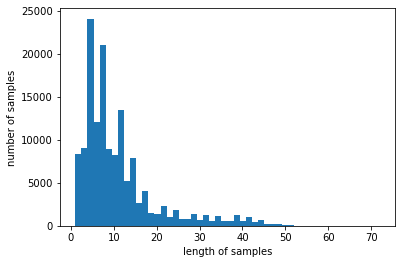

In [49]:
### 동일한 길이로 패딩
# 전체 데이터의 길이에 대한 분포 확인
#print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
#print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [50]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율 확인
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    #print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

# 동일한 길이 설정을 위한 전체에 대한 비율 확인
max_len = 30
below_threshold_len(max_len, X_train)

# 모두 동일한 길이로 설정(max_len)
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [51]:
### LSTM 모델 설정

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [52]:
### Model 학습 및 생성
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1937/1939 [============================>.] - ETA: 0s - loss: 0.3889 - acc: 0.8241
Epoch 00001: val_acc improved from -inf to 0.84279, saving model to best_model.h5
1939/1939 [==============================] - 36s 19ms/step - loss: 0.3889 - acc: 0.8241 - val_loss: 0.3521 - val_acc: 0.8428
Epoch 2/15
1937/1939 [============================>.] - ETA: 0s - loss: 0.3271 - acc: 0.8580
Epoch 00002: val_acc improved from 0.84279 to 0.85455, saving model to best_model.h5
1939/1939 [==============================] - 36s 18ms/step - loss: 0.3270 - acc: 0.8581 - val_loss: 0.3373 - val_acc: 0.8546
Epoch 3/15
1936/1939 [============================>.] - ETA: 0s - loss: 0.3016 - acc: 0.8719
Epoch 00003: val_acc improved from 0.85455 to 0.86102, saving model to best_model.h5
1939/1939 [==============================] - 35s 18ms/step - loss: 0.3016 - acc: 0.8719 - val_loss: 0.3257 - val_acc: 0.8610
Epoch 4/15
1937/1939 [============================>.] - ETA: 0s - loss: 0.2832 - acc: 0.8822
E

In [53]:
### 생성된 모델 평가
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 6s 4ms/step - loss: 0.3346 - acc: 0.8531

 테스트 정확도: 0.8531


In [55]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    result = 0
    if(score > 0.5):
        #print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
        result = 1
    else:
        #print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
        result = 0
    
    return result

In [56]:
eval_data = pd.read_csv('./[전처리]ko_data.csv', engine='python', encoding='utf-8')
eval_data['Predicted'] = 0

for i in range(len(eval_data)):
    Predicted = sentiment_predict(eval_data['Sentence'][i])
    eval_data['Predicted'][i] = Predicted
    
eval_data.drop(['Sentence'], axis='columns', inplace=True)
eval_data.to_csv("result.csv", index=False)

<ipython-input-56-08d71f739e41>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_data['Predicted'][i] = Predicted
